#10.	HR-аналитика: текучесть кадров в IT-компании
Проведите анализ данных о сотрудниках IT-компании: работа с БД, EDA для выявления факторов текучести, анализ временных рядов найма, построение модели классификации для прогнозирования оттока сотрудников.
База данных: hr_analytics.db


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Подключение к базе данных
conn = sqlite3.connect('hr_analytics.db')
print("Подключение к базе данных установлено.")

Подключение к базе данных установлено.


In [3]:
# Проверим список всех таблиц в базе данных
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
print("Таблицы в базе данных:")
print(tables)

Таблицы в базе данных:
          name
0  departments
1    employees
2   attendance


In [4]:
# Посмотрим структуру каждой таблицы
for table in tables['name']:
    print(f"\nСтруктура таблицы '{table}':")
    try:
        structure = pd.read_sql_query(f"PRAGMA table_info({table})", conn)
        print(structure[['name', 'type']])
        # Покажем первые несколько строк для понимания данных
        sample = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 3", conn)
        print("\nПример данных:")
        print(sample)
    except Exception as e:
        print(f"Ошибка при чтении таблицы {table}: {e}")


Структура таблицы 'departments':
             name     type
0    DepartmentID  INTEGER
1  DepartmentName     TEXT
2            City     TEXT
3          Budget     REAL

Пример данных:
   DepartmentID DepartmentName             City     Budget
0             1             IT           Москва  5000000.0
1             2      Маркетинг           Москва  2000000.0
2             3        Продажи  Санкт-Петербург  3000000.0

Структура таблицы 'employees':
               name     type
0        EmployeeID  INTEGER
1              Name     TEXT
2        Department     TEXT
3          Position     TEXT
4          HireDate     TEXT
5            Salary     REAL
6  PerformanceScore  INTEGER
7           HasLeft  INTEGER

Пример данных:
   EmployeeID                Name Department              Position  \
0           1  Александров А.А. 1         HR           HR-менеджер   
1           2      Лебедев Л.Л. 2    Финансы   Финансовый аналитик   
2           3      Федоров Ф.Ф. 3    Продажи  Менеджер по пр

##Часть 1. Работа с SQL и Pandas (10 минут)

###1. Напишите SQL-запрос для получения информации о уволившихся сотрудниках (HasLeft = 1). Выведите: имя, отдел, должность, зарплату и показатель эффективности.

Загрузите результат в DataFrame left_employees.

In [7]:
left_employees = pd.read_sql_query("""
    SELECT
        e.Name,
        d.DepartmentName as Department,
        e.Position,
        e.Salary,
        e.PerformanceScore
    FROM
        employees e
    JOIN
        departments d ON e.Department = d.DepartmentName
    WHERE
        e.HasLeft = 1;
""", conn)

# Проверка результата
print(f"Количество уволившихся сотрудников: {len(left_employees)}")
print("\nПервые 5 строк:")
left_employees.head()

Количество уволившихся сотрудников: 13

Первые 5 строк:


,Name,Department,Position,Salary,PerformanceScore
0,Лебедев Л.Л. 2,Финансы,Финансовый аналитик,192034.0,2
1,Федоров Ф.Ф. 3,Продажи,Менеджер по продажам,123380.0,1
2,Лебедев Л.Л. 5,Продажи,Менеджер по продажам,165322.0,1
3,Новиков Н.Н. 6,HR,Рекрутер,238960.0,3
4,Новиков Н.Н. 8,IT,Аналитик,227708.0,1


###2. Используя LEFT JOIN, получите данные о всех сотрудниках с информацией об их отделах. Загрузите в DataFrame all_employees.

С помощью Pandas:

Создайте столбец Tenure (стаж работы) — количество полных лет с даты найма до текущей даты
Рассчитайте процент оттока (HasLeft=1) для каждого отдела
Определите отдел с наибольшей текучестью кадров

In [10]:
# SQL запрос с LEFT JOIN для получения данных о всех сотрудниках с информацией об отделах
query2 = """
SELECT
    e.*,
    d.DepartmentName as DeptName,
    d.City,
    d.Budget
FROM
    employees e
LEFT JOIN
    departments d ON e.Department = d.DepartmentName
"""

all_employees = pd.read_sql_query(query2, conn)
print("Первые 5 строк all_employees:")
print(all_employees.head())
print(f"\nРазмер DataFrame: {all_employees.shape}")

Первые 5 строк all_employees:
   EmployeeID                Name Department              Position  \
0           1  Александров А.А. 1         HR           HR-менеджер   
1           2      Лебедев Л.Л. 2    Финансы   Финансовый аналитик   
2           3      Федоров Ф.Ф. 3    Продажи  Менеджер по продажам   
3           4       Петров П.П. 4  Маркетинг            Маркетолог   
4           5      Лебедев Л.Л. 5    Продажи  Менеджер по продажам   

     HireDate    Salary  PerformanceScore  HasLeft   DeptName  \
0  2020-05-16  229224.0                 5        0         HR   
1  2023-04-26  192034.0                 2        1    Финансы   
2  2022-01-18  123380.0                 1        1    Продажи   
3  2022-08-11  197595.0                 5        0  Маркетинг   
4  2022-04-01  165322.0                 1        1    Продажи   

              City     Budget  
0           Москва  1500000.0  
1  Санкт-Петербург  2500000.0  
2  Санкт-Петербург  3000000.0  
3           Москва  2000000.0 

In [97]:
# Создание столбца Tenure (стаж работы)
# HireDate в формат datetime
all_employees['HireDate'] = pd.to_datetime(all_employees['HireDate'], errors='coerce')

# Рассчитываем стаж в полных годах (от текущей даты до даты найма)
current_date = pd.Timestamp.now()
all_employees['Tenure'] = ((current_date - all_employees['HireDate']).dt.days / 365.25).astype(int)

print("\nДанные с добавленным столбцом Tenure:")
all_employees[['Name', 'HireDate', 'Tenure', 'HasLeft']].head()


Данные с добавленным столбцом Tenure:


,Name,HireDate,Tenure,HasLeft
0,Александров А.А. 1,2020-05-16,5,0
1,Лебедев Л.Л. 2,2023-04-26,2,1
2,Федоров Ф.Ф. 3,2022-01-18,4,1
3,Петров П.П. 4,2022-08-11,3,0
4,Лебедев Л.Л. 5,2022-04-01,3,1


In [13]:
# Анализ оттока по отделам
# Рассчитываем процент оттока для каждого отдела
turnover_by_dept = all_employees.groupby('DeptName').agg(
    total_employees=('EmployeeID', 'count'),
    left_employees=('HasLeft', 'sum')
).reset_index()

# Добавляем столбец с процентом оттока
turnover_by_dept['turnover_rate'] = (turnover_by_dept['left_employees'] / turnover_by_dept['total_employees'] * 100).round(2)

print("\nОтток по отделам:")
print(turnover_by_dept)


Отток по отделам:
    DeptName  total_employees  left_employees  turnover_rate
0         HR                7               3          42.86
1         IT                8               3          37.50
2  Маркетинг                6               1          16.67
3    Продажи                9               2          22.22
4    Финансы               10               4          40.00


In [15]:
# Определяем отдел с наибольшей текучестью кадров
max_turnover_dept = turnover_by_dept.loc[turnover_by_dept['turnover_rate'].idxmax()]
print(f"\nОтдел с наибольшей текучестью кадров: {max_turnover_dept['DeptName']}")
print(f"Процент оттока: {max_turnover_dept['turnover_rate']}%")
print(f"Количество уволившихся: {int(max_turnover_dept['left_employees'])} из {int(max_turnover_dept['total_employees'])}")


Отдел с наибольшей текучестью кадров: HR
Процент оттока: 42.86%
Количество уволившихся: 3 из 7


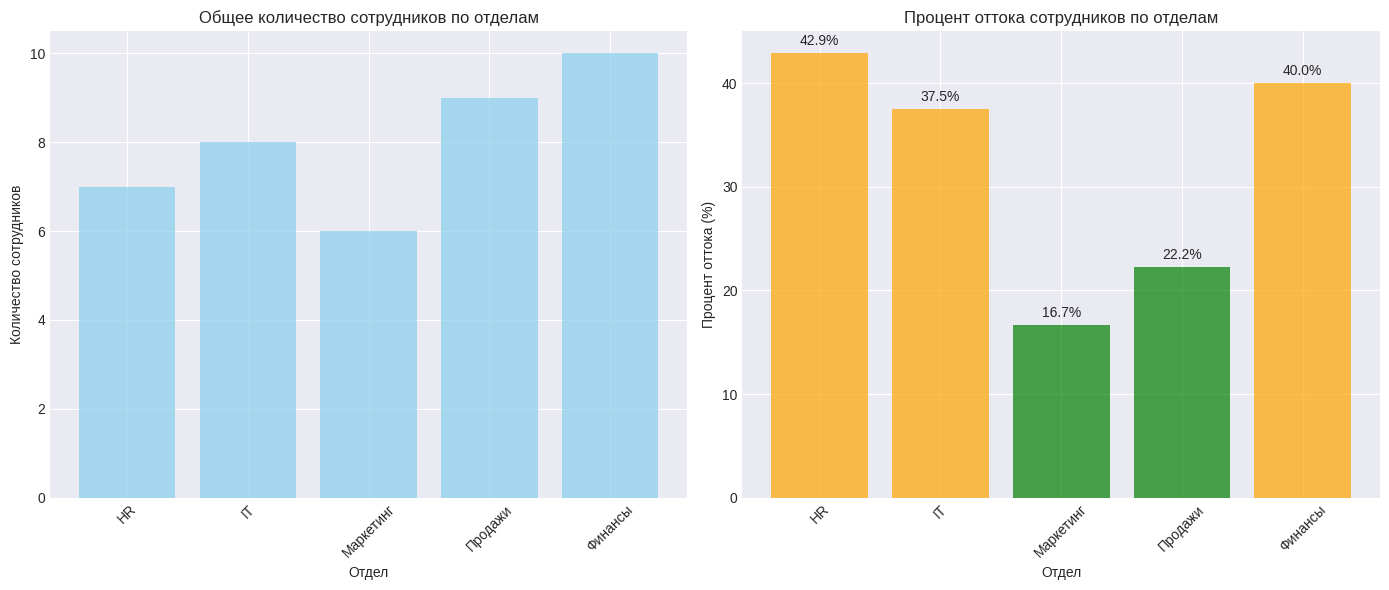

In [16]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График 1: Количество сотрудников по отделам
axes[0].bar(turnover_by_dept['DeptName'], turnover_by_dept['total_employees'], color='skyblue', alpha=0.7)
axes[0].set_title('Общее количество сотрудников по отделам')
axes[0].set_xlabel('Отдел')
axes[0].set_ylabel('Количество сотрудников')
axes[0].tick_params(axis='x', rotation=45)

# График 2: Процент оттока по отделам
colors = ['green' if rate < 30 else 'orange' if rate < 50 else 'red'
          for rate in turnover_by_dept['turnover_rate']]
bars = axes[1].bar(turnover_by_dept['DeptName'], turnover_by_dept['turnover_rate'], color=colors, alpha=0.7)
axes[1].set_title('Процент оттока сотрудников по отделам')
axes[1].set_xlabel('Отдел')
axes[1].set_ylabel('Процент оттока (%)')
axes[1].tick_params(axis='x', rotation=45)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



Цветовая кодировка для процента оттока (зеленый < 30%, оранжевый < 50%, красный ≥ 50%)


In [17]:
# Дополнительный анализ: стаж работы уволившихся vs оставшихся сотрудников
print("\nАнализ стажа работы:")
left_employees = all_employees[all_employees['HasLeft'] == 1]
stayed_employees = all_employees[all_employees['HasLeft'] == 0]

print(f"Средний стаж уволившихся сотрудников: {left_employees['Tenure'].mean():.1f} лет")
print(f"Средний стаж оставшихся сотрудников: {stayed_employees['Tenure'].mean():.1f} лет")


Анализ стажа работы:
Средний стаж уволившихся сотрудников: 3.5 лет
Средний стаж оставшихся сотрудников: 3.5 лет


In [18]:
# Статистика по стажу в разрезе отдела и увольнения
tenure_analysis = all_employees.groupby(['DeptName', 'HasLeft']).agg(
    avg_tenure=('Tenure', 'mean'),
    count=('EmployeeID', 'count')
).round(2).reset_index()

print("\nСтатистика стажа по отделам:")
print(tenure_analysis)


Статистика стажа по отделам:
    DeptName  HasLeft  avg_tenure  count
0         HR        0        3.25      4
1         HR        1        3.33      3
2         IT        0        3.20      5
3         IT        1        4.33      3
4  Маркетинг        0        3.40      5
5  Маркетинг        1        2.00      1
6    Продажи        0        3.86      7
7    Продажи        1        3.50      2
8    Финансы        0        3.50      6
9    Финансы        1        3.25      4


##Часть 2. Исследовательский анализ данных (EDA) (10 минут)

###1. Используя DataFrame all_employees:

Выведите описательную статистику для столбцов Salary и PerformanceScore
Постройте гистограмму распределения зарплат
Постройте boxplot для зарплат в разрезе статуса сотрудника (HasLeft)

##### 1. Описательная статистика для Salary и PerformanceScore

In [32]:
print("\nЗарплата (Salary):")
all_employees['Salary'].describe()


Зарплата (Salary):


,Salary
count,40.00000
mean,142167.97500
std,62625.47673
min,54684.00000
25%,84684.50000
50%,132791.50000
75%,193424.25000
max,243662.00000


# Основные характеристики Salary

Широкий разброс: Стандартное отклонение 62 625 указывает на значительную неоднородность зарплат — есть как низкооплачиваемые, так и высокие позиции.

Средняя выше медианы: 142 168 против 132 792 говорит о правосторонней асимметрии (несколько высокооплачиваемых сотрудников тянут среднее вверх).

Квартили: 25% получают менее 84 685, 75% — менее 193 424, что охватывает основной диапазон типичных зарплат.

In [23]:
print("\nОценка эффективности (PerformanceScore):")
all_employees['PerformanceScore'].describe()


Оценка эффективности (PerformanceScore):


,PerformanceScore
count,40.000000
mean,3.125000
std,1.604281
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,5.000000


**Основные характеристики PerformanceScore**

Средний уровень: 3.125 баллов указывает на удовлетворительную общую производительность большинства сотрудников.

Большой разброс: Стандартное отклонение 1.60 говорит о полярности — есть как слабые (25% с оценкой 1), так и отличные сотрудники (75% с оценкой 5).

Медиана 3: Половина персонала показывает средний результат, что является типичным для корпоративных оценок.

In [33]:
#Корреляция между зп и эффективностью
print("\nКорреляция между зарплатой и оценкой эффективности:")
correlation = all_employees['Salary'].corr(all_employees['PerformanceScore'])
print(f"{correlation:.4f} (1 = полная положительная корреляция, -1 = полная отрицательная, 0 = нет корреляции)")


Корреляция между зарплатой и оценкой эффективности:
0.0702 (1 = полная положительная корреляция, -1 = полная отрицательная, 0 = нет корреляции)


**Вывод**: Слабая положительная связь: Коэффициент 0.07 близок к нулю — зарплата почти не зависит от оценки эффективности, в связи с чем нет мотивации получать высокую оценку на работе

In [26]:
# Сравнение по группам HasLeft
print("\nСРАВНЕНИЕ ПО СТАТУСУ СОТРУДНИКА (HasLeft):")
for status, label in [(0, "Работающие"), (1, "Уволившиеся")]:
    group = all_employees[all_employees['HasLeft'] == status]
    print(f"\n{label} (HasLeft={status}):")
    print(f"  Средняя зарплата: {group['Salary'].mean():.0f}")
    print(f"  Средняя оценка: {group['PerformanceScore'].mean():.2f}")
    print(f"  Количество: {len(group)}")


СРАВНЕНИЕ ПО СТАТУСУ СОТРУДНИКА (HasLeft):

Работающие (HasLeft=0):
  Средняя зарплата: 145704
  Средняя оценка: 3.44
  Количество: 27

Уволившиеся (HasLeft=1):
  Средняя зарплата: 134824
  Средняя оценка: 2.46
  Количество: 13


**Вывод**: Уволившиеся сотрудники демонстрируют более низкие зарплаты (134 824 против 145 704) и оценки эффективности (2.46 против 3.44), что указывает на связь текучести с производительностью.

#### 2. Гистограмма распределения зарплат

Text(0.02, 0.98, 'Всего сотрудников: 40')

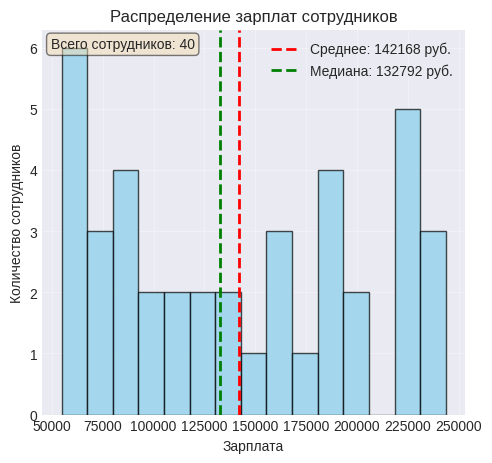

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(all_employees['Salary'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)

# линии для среднего и медианы
mean_salary = all_employees['Salary'].mean()
median_salary = all_employees['Salary'].median()

plt.axvline(mean_salary, color='red', linestyle='--', linewidth=2,
            label=f'Среднее: {mean_salary:.0f} руб.')
plt.axvline(median_salary, color='green', linestyle='--', linewidth=2,
            label=f'Медиана: {median_salary:.0f} руб.')

# Настройка осей и заголовка
plt.xlabel('Зарплата')
plt.ylabel('Количество сотрудников')
plt.title('Распределение зарплат сотрудников')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

#  информацию о статистике
plt.text(0.02, 0.98, f'Всего сотрудников: {len(all_employees)}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

**Форма распределения:**

1. Зарплаты имеют правостороннее (положительное) асимметричное распределение
2. Большинство сотрудников сосредоточено в левой части графика (более низкие зарплаты)
3. Есть "длинный хвост" в правой части, что указывает на наличие сотрудников с высокими зарплатами

**Анализ среднего и медианы:**

1. Средняя зарплата выше медианной, что характерно для распрделения с правосторонней асимметрией - несколько высоких зарплат "тянут" среднее значение вверх
2. Медиана лучше отражает типичную зарплату большинства сотрудников

**Основной диапазон зарплат:**

Большинство сотрудников (пик гистограммы) имеют зарплаты в диапазоне 110,000 - 140,000 рублей

**Можно выделить несколько групп:**

* Низкооплачиваемые: до 110,000

* Основная масса: 110,000 - 140,000

* Выше среднего: 140,000 - 200,000

* Высокооплачиваемые: свыше 200,000

#### 3. Boxplot для зарплат в разрезе статуса сотрудника (HasLeft)

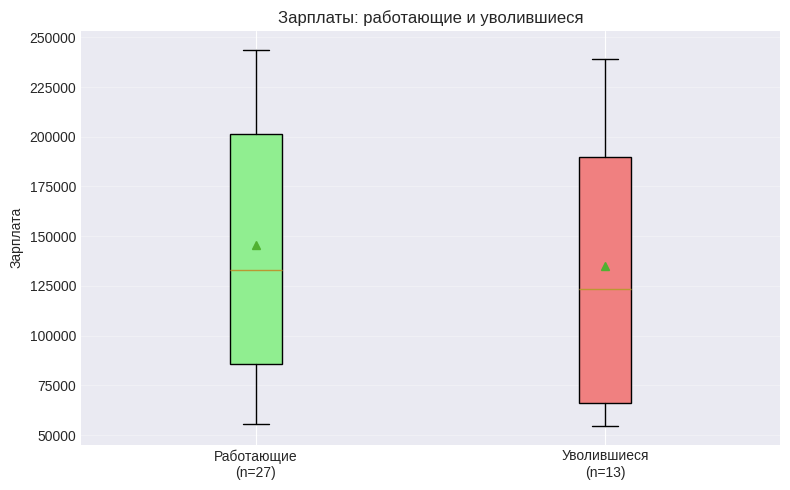

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))

working = all_employees[all_employees['HasLeft'] == 0]['Salary']
left = all_employees[all_employees['HasLeft'] == 1]['Salary']

bp = ax.boxplot([working, left],
                labels=['Работающие\n(n=27)', f'Уволившиеся\n(n={len(left)})'],
                patch_artist=True, showmeans=True)

# Цвета и сетка
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors): patch.set_facecolor(color)
ax.grid(True, alpha=0.3, axis='y')

ax.set_ylabel('Зарплата')
ax.set_title('Зарплаты: работающие и уволившиеся')

plt.tight_layout()
plt.show()

In [41]:
# Сводная таблица статистики зарплат
stats = pd.DataFrame({
    'Группа': ['Работающие (0)', 'Уволившиеся (1)'],
    'n': [len(working_salaries), len(left_salaries)],
    'Средняя': [working_salaries.mean(), left_salaries.mean()],
    'Медиана': [working_salaries.median(), left_salaries.median()],
    'Мин': [working_salaries.min(), left_salaries.min()],
    'Макс': [working_salaries.max(), left_salaries.max()]
}).round(0).astype({'Средняя': 'int', 'Медиана': 'int', 'Мин': 'int', 'Макс': 'int'})

print("\nСТАТИСТИКА ЗАРПЛАТ ПО ГРУППАМ HasLeft")
print("="*50)
print(stats.to_string(index=False))

# Разница
diff = working_salaries.mean() - left_salaries.mean()
print(f"\nРазница в средних: {diff:+.0f}  ({diff/working_salaries.mean()*100:+.1f}%)")



СТАТИСТИКА ЗАРПЛАТ ПО ГРУППАМ HasLeft
         Группа  n  Средняя  Медиана   Мин   Макс
 Работающие (0) 27   145704   133089 55667 243662
Уволившиеся (1) 13   134824   123380 54684 238960

Разница в средних: +10880  (+7.5%)


**Выводы**

* Зарплата не основной фактор: Разница в 10.9K несущественна для текучести — диапазоны почти совпадают.

* Нижний сегмент рискован: Уволившиеся чаще из нижней половины (медиана ниже на 7%), но топ-зарплаты сохраняются.

### 2. Бизнес-гипотеза: "Сотрудники с более низким показателем эффективности чаще увольняются."

Постройте bar chart среднего показателя эффективности для уволившихся и работающих сотрудников

Рассчитайте среднее значение PerformanceScore для каждой группы

Сделайте вывод: подтверждается ли гипотеза? Какие HR-стратегии можно предложить?

In [42]:
# Проверка гипотезы: "Сотрудники с более низким показателем эффективности чаще увольняются"
# Рассчитываем среднее значение PerformanceScore для каждой группы
performance_by_status = all_employees.groupby('HasLeft')['PerformanceScore'].agg(['mean', 'count']).round(2)
performance_by_status.index = ['Работающие (0)', 'Уволившиеся (1)']
print("\nСРЕДНИЕ ПОКАЗАТЕЛИ ЭФФЕКТИВНОСТИ ПО ГРУППАМ:")
print(performance_by_status)


СРЕДНИЕ ПОКАЗАТЕЛИ ЭФФЕКТИВНОСТИ ПО ГРУППАМ:
                 mean  count
Работающие (0)   3.44     27
Уволившиеся (1)  2.46     13


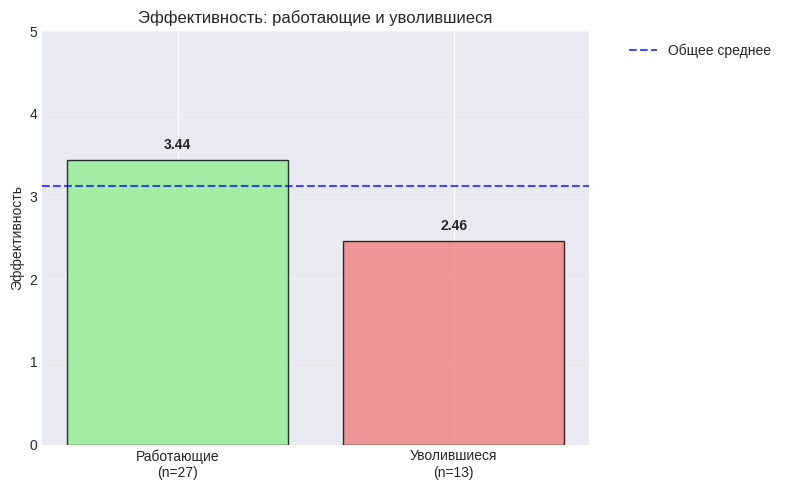

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

# Данные
groups = ['Работающие\n(n=27)', 'Уволившиеся\n(n=13)']
means = [all_employees[all_employees['HasLeft'] == 0]['PerformanceScore'].mean(),
         all_employees[all_employees['HasLeft'] == 1]['PerformanceScore'].mean()]

# Столбцы + значения
bars = ax.bar(groups, means, color=['lightgreen', 'lightcoral'],
              alpha=0.8, edgecolor='black')
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, mean + 0.1,
            f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

# Линия среднего + сетка
ax.axhline(all_employees['PerformanceScore'].mean(), color='blue', ls='--',
           alpha=0.7, label='Общее среднее')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 5)
ax.set_ylabel('Эффективность')
ax.set_title('Эффективность: работающие и уволившиеся')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

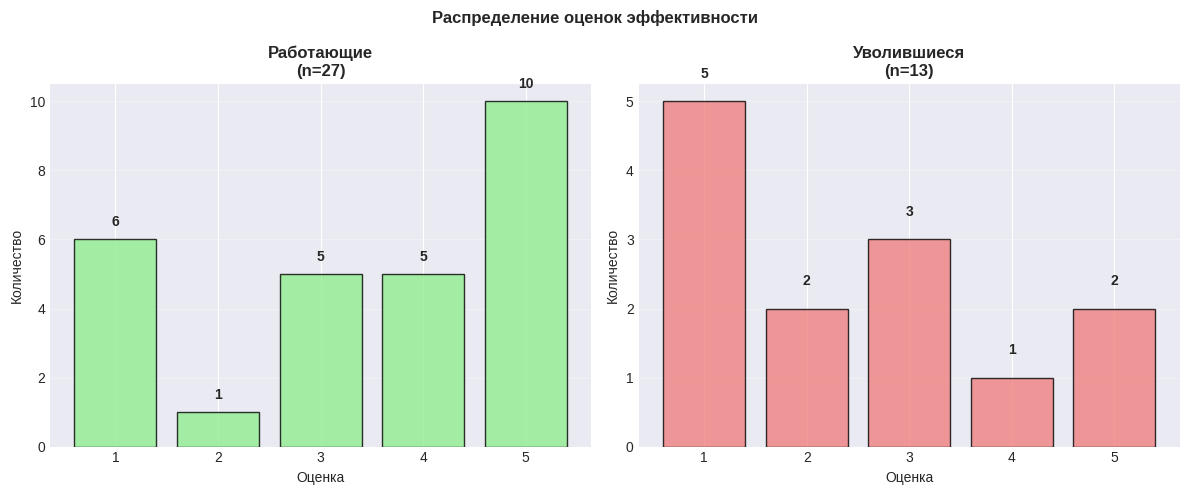

In [48]:
# Компактные гистограммы оценок эффективности
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (status, label, color) in enumerate([
    (0, 'Работающие\n(n=27)', 'lightgreen'),
    (1, 'Уволившиеся\n(n=13)', 'lightcoral')
]):
    group = all_employees[all_employees['HasLeft'] == status]['PerformanceScore']
    counts = group.value_counts().sort_index()

    axes[idx].bar(counts.index, counts.values, color=color, alpha=0.8, edgecolor='black')
    axes[idx].set_title(label, fontweight='bold')
    axes[idx].set_xlabel('Оценка')
    axes[idx].set_ylabel('Количество')
    axes[idx].set_xticks([1,2,3,4,5])
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Значения на столбцах
    for i, v in enumerate(counts.values):
        axes[idx].text(i+1, v+0.3, str(v), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Распределение оценок эффективности', fontweight='bold')
plt.tight_layout()
plt.show()


In [53]:
print("АНАЛИЗ ЭФФЕКТИВНОСТИ")

# Распределение + ключевые метрики в таблице
stats = []
for status, label in [(0, "Работающие"), (1, "Уволившиеся")]:
    group = all_employees[all_employees['HasLeft'] == status]
    print(f"\n{label} (n={len(group)}):")
    low = len(group[group['PerformanceScore'] <= 2])
    high = len(group[group['PerformanceScore'] >= 4])
    stats.extend([[label, len(group), low, low/len(group)*100, high, high/len(group)*100]])

    for score in [1,2,3,4,5]:
        count = len(group[group['PerformanceScore'] == score])
        print(f"  {score}: {count:>2} ({count/len(group)*100:>5.1f}%)")

# Таблица сводки
df_stats = pd.DataFrame(stats, columns=['Группа','n','Низкие(1-2)','%низкие','Высокие(4-5)','%высокие'])
print(f"\n{df_stats.to_string(index=False, float_format='%.1f')}")

# Гипотеза и разница
diff = working_mean - left_mean
print(f"\n{'='*70}")
print(f"ГИПОТЕЗА: {left_mean:.2f} < {working_mean:.2f} | РАЗНИЦА: {diff:+.2f} ({diff/working_mean*100:+.1f}%)")


АНАЛИЗ ЭФФЕКТИВНОСТИ

Работающие (n=27):
  1:  6 ( 22.2%)
  2:  1 (  3.7%)
  3:  5 ( 18.5%)
  4:  5 ( 18.5%)
  5: 10 ( 37.0%)

Уволившиеся (n=13):
  1:  5 ( 38.5%)
  2:  2 ( 15.4%)
  3:  3 ( 23.1%)
  4:  1 (  7.7%)
  5:  2 ( 15.4%)

     Группа  n  Низкие(1-2)  %низкие  Высокие(4-5)  %высокие
 Работающие 27            7     25.9            15      55.6
Уволившиеся 13            7     53.8             3      23.1

ГИПОТЕЗА: 2.46 < 3.44 | РАЗНИЦА: +0.98 (+28.5%)


## 3. Анализ временных рядов

Получите из базы данных ежемесячную статистику количества нанятых сотрудников.

Преобразуйте столбец с датой найма в формат datetime

Выполните ресэмплинг в месячные агрегаты (количество нанятых за месяц)

Постройте линейный график динамики найма

Извлеките признак "месяц" и определите, в какие месяцы компания нанимает больше всего сотрудников

In [56]:
# Получаем данные о найме из базы данных
hire_query = """
SELECT
    HireDate,
    COUNT(*) as hire_count
FROM
    employees
GROUP BY
    HireDate
ORDER BY
    HireDate
"""

hire_data = pd.read_sql_query(hire_query, conn)
print(f"\nОбщее количество записей о найме: {len(hire_data)}")
print("\nПервые 5 записей:")
hire_data.head()


Общее количество записей о найме: 39

Первые 5 записей:


,HireDate,hire_count
0,2020-02-25,1
1,2020-03-07,1
2,2020-05-01,1
3,2020-05-16,1
4,2020-06-09,1


In [57]:
hire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   HireDate    39 non-null     object
 1   hire_count  39 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 756.0+ bytes


In [58]:
# Пеобразование столбец с датой найма в формат datetime
hire_data['HireDate'] = pd.to_datetime(hire_data['HireDate'], errors='coerce')

In [59]:
hire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   HireDate    39 non-null     datetime64[ns]
 1   hire_count  39 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 756.0 bytes


In [60]:
# Преобразуем каждую дату найма в начало месяца для группировки
hire_data['HireMonth'] = hire_data['HireDate'].dt.to_period('M')

In [61]:
hire_data.head()

,HireDate,hire_count,HireMonth
0,2020-02-25,1,2020-02
1,2020-03-07,1,2020-03
2,2020-05-01,1,2020-05
3,2020-05-16,1,2020-05
4,2020-06-09,1,2020-06


In [63]:
# Выполняем ресэмплинг в месячные агрегаты
monthly_hire_stats = hire_data.groupby('HireMonth')['hire_count'].sum().reset_index()
monthly_hire_stats['HireMonth'] = monthly_hire_stats['HireMonth'].dt.to_timestamp()
print(f"\nКоличество уникальных месяцев: {len(monthly_hire_stats)}")


Количество уникальных месяцев: 28


In [66]:
print("\nМЕСЯЧНАЯ СТАТИСТИКА НАЙМА:")

monthly_hire_stats.sort_values('HireMonth')


МЕСЯЧНАЯ СТАТИСТИКА НАЙМА:


,HireMonth,hire_count
0,2020-02-01,1
1,2020-03-01,1
2,2020-05-01,2
3,2020-06-01,1
4,2020-07-01,1
5,2020-09-01,2
6,2020-11-01,1
7,2021-02-01,2
8,2021-03-01,2
9,2021-04-01,1


In [67]:
# Основные статистики
print("\nОСНОВНЫЕ СТАТИСТИКИ НАЙМА:")
print("=" * 40)
print(f"Всего нанято сотрудников: {monthly_hire_stats['hire_count'].sum()}")
print(f"Среднее количество наймов в месяц: {monthly_hire_stats['hire_count'].mean():.1f}")
print(f"Максимальное количество наймов в месяц: {monthly_hire_stats['hire_count'].max()}")
print(f"Минимальное количество наймов в месяц: {monthly_hire_stats['hire_count'].min()}")
print(f"Стандартное отклонение: {monthly_hire_stats['hire_count'].std():.2f}")


ОСНОВНЫЕ СТАТИСТИКИ НАЙМА:
Всего нанято сотрудников: 40
Среднее количество наймов в месяц: 1.4
Максимальное количество наймов в месяц: 3
Минимальное количество наймов в месяц: 1
Стандартное отклонение: 0.63


In [69]:
# Определяем лучшие месяцы для найма
print("\nТОП-5 МЕСЯЦЕВ ПО КОЛИЧЕСТВУ НАЙМОВ:")
print("=" * 40)
top_months = monthly_hire_stats.sort_values('hire_count', ascending=False).head(5)
for idx, row in top_months.iterrows():
    month_name = row['HireMonth'].strftime('%B %Y')
    print(f"{month_name}: {row['hire_count']} наймов")


ТОП-5 МЕСЯЦЕВ ПО КОЛИЧЕСТВУ НАЙМОВ:
April 2023: 3 наймов
March 2023: 3 наймов
May 2020: 2 наймов
March 2021: 2 наймов
April 2022: 2 наймов


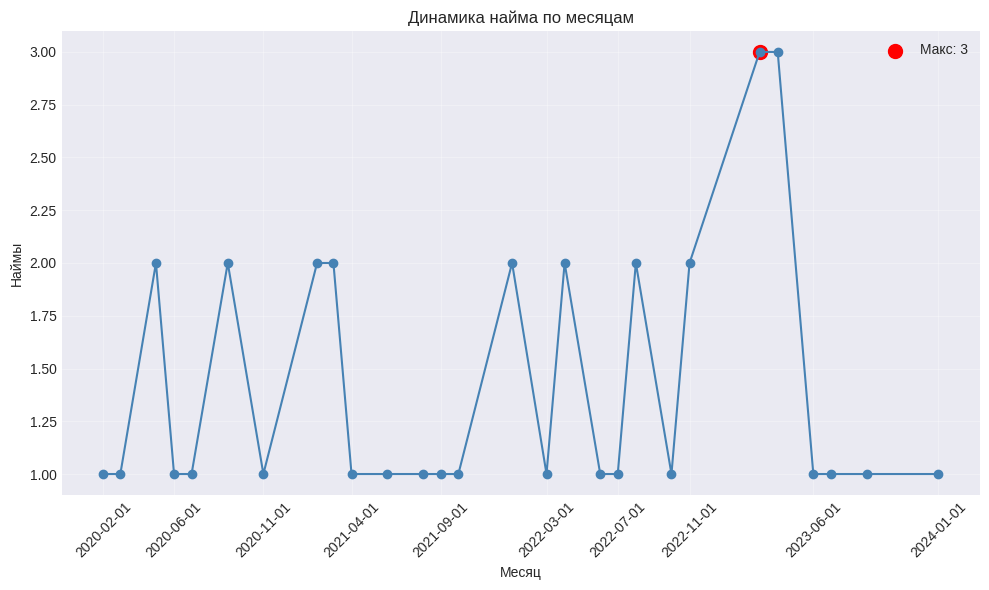

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_hire_stats['HireMonth'], monthly_hire_stats['hire_count'], 'o-', color='steelblue')
plt.scatter(max_month['HireMonth'], max_month['hire_count'], color='red', s=100, label=f'Макс: {max_month["hire_count"]}')

plt.title('Динамика найма по месяцам')
plt.xlabel('Месяц'); plt.ylabel('Наймы')
plt.grid(True, alpha=0.3)

# Выбираем только месяцы каждого квартала (например: Янв, Апр, Июл, Окт)
quarterly_ticks = monthly_hire_stats['HireMonth'][::3]  # Каждые 3 месяца
plt.xticks(quarterly_ticks, rotation=45)

plt.legend()
plt.tight_layout(); plt.show()

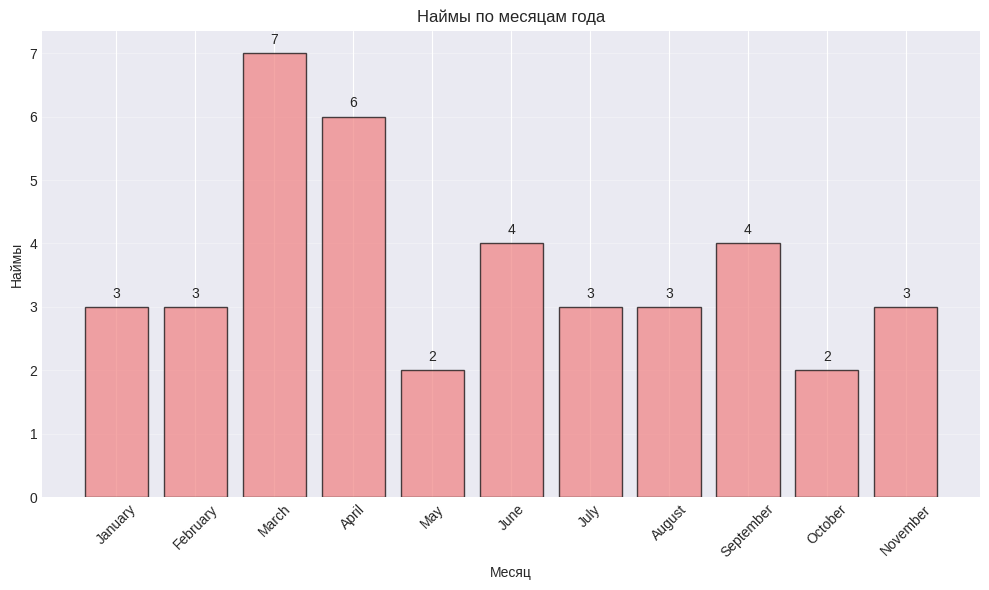

In [74]:
# График 2: Распределение по месяцам года
plt.figure(figsize=(10, 6))
monthly_distribution_sorted = monthly_distribution.copy()
monthly_distribution_sorted['MonthName'] = pd.Categorical(monthly_distribution_sorted['MonthName'],
                                                         categories=['January','February','March','April','May','June',
                                                                    'July','August','September','October','November','December'], ordered=True)
monthly_distribution_sorted = monthly_distribution_sorted.sort_values('MonthName')

plt.bar(monthly_distribution_sorted['MonthName'], monthly_distribution_sorted['hire_count'],
        color='lightcoral', alpha=0.7, edgecolor='black')
for i, v in enumerate(monthly_distribution_sorted['hire_count']):
    plt.text(i, v+0.1, str(v), ha='center', va='bottom')
plt.title('Наймы по месяцам года')
plt.xlabel('Месяц'); plt.ylabel('Наймы'); plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout(); plt.show()

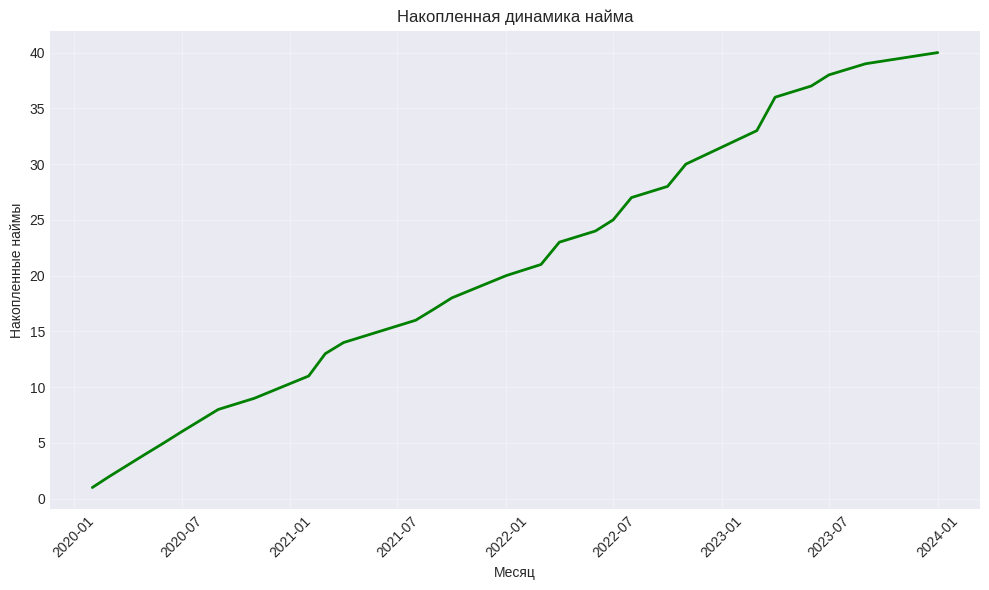

In [75]:
# График 3: Накопленный найм
plt.figure(figsize=(10, 6))
monthly_hire_stats['CumulativeHires'] = monthly_hire_stats['hire_count'].cumsum()
plt.plot(monthly_hire_stats['HireMonth'], monthly_hire_stats['CumulativeHires'], 'g-', linewidth=2)
plt.title('Накопленная динамика найма')
plt.xlabel('Месяц'); plt.ylabel('Накопленные наймы')
plt.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

**Общий рост найма**

За 4 года общее количество наймов составило примерно 35-40 человек

**Периоды разной интенсивности найма:**

* 2020 год: Медленный, но стабильный рост (примерно 5-7 наймов за год)

* 2021 год: Ускорение темпов (кривая становится круче, +10-15 наймов за год)

* 2022 год: Наиболее интенсивный период (кривая наиболее крутая, +15-20 наймов)

* 2023 год: Замедление роста (кривая снова становится более пологой)

**Ключевые точки перелома тенденции:**

* Середина 2021 года: Начало ускорения темпов найма

* Середина 2022 года: Пик интенсивности найма

* Середина 2023 года: Заметное замедление темпов

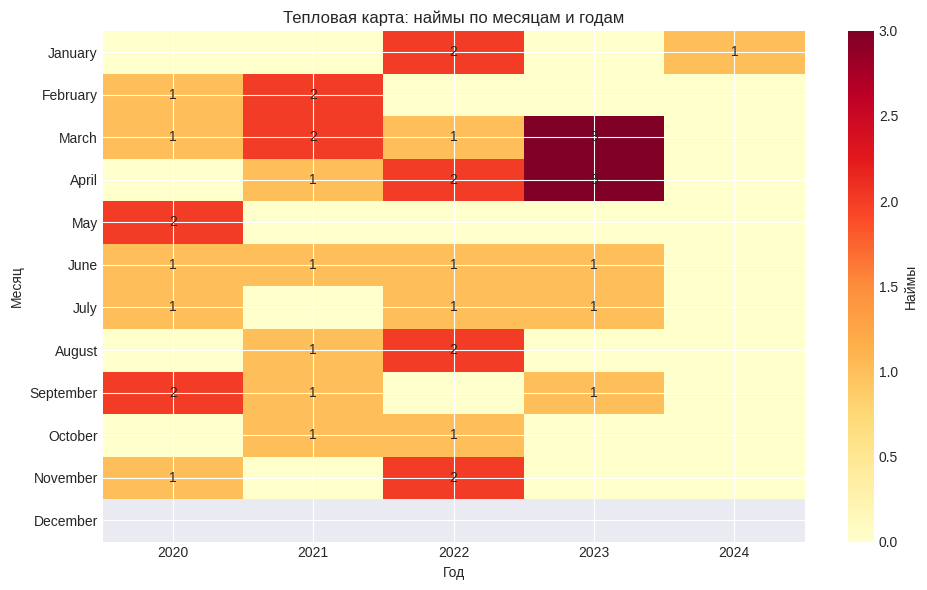

In [76]:
# График 4: Тепловая карта
plt.figure(figsize=(10, 6))
hire_data['Year'] = hire_data['HireDate'].dt.year
heatmap = hire_data.pivot_table(values='hire_count', index='MonthName', columns='Year',
                               aggfunc='sum', fill_value=0).reindex(['January','February','March','April','May','June',
                                                                    'July','August','September','October','November','December'])
im = plt.imshow(heatmap.values, cmap='YlOrRd', aspect='auto')
plt.title('Тепловая карта: наймы по месяцам и годам')
plt.xlabel('Год'); plt.ylabel('Месяц')
plt.xticks(range(len(heatmap.columns)), heatmap.columns.astype(int))
plt.yticks(range(len(heatmap.index)), heatmap.index)
plt.colorbar(im, label='Наймы')
for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
        if heatmap.values[i,j] > 0:
            plt.text(j, i, int(heatmap.values[i,j]), ha='center', va='center')
plt.tight_layout(); plt.show()

Весенний фокус: Март-апрель — стабильно активные месяцы (12 наймов за 5 лет)

Осенний спад: Сентябрь-декабрь — минимальная активность

**Годовые циклы:**

* 2020: Равномерное распределение

* 2021: Концентрация в Q1-Q2

* 022: Наиболее сбалансированный год

* 2023: Резкий пик весной → спад

**Возможные причины паттернов:**

* Бюджетный цикл: Найм активизируется после утверждения годовых бюджетов (Q1)

* Проектный подход: Найм под конкретные проекты, запускаемые весной

* Конец года: Декабрьские паузы связаны с закрытием финансового года

### Для временного ряда количества найма создайте:

Hires_Lag1 — количество найма за предыдущий месяц

Rolling_Mean_6 — скользящее среднее за 6 месяцев

Удалите строки с NaN и выведите последние 5 строк результата.

In [81]:
# 1. Группируем по месяцам для создания временного ряда
hires_agg = hire_data.groupby('HireMonth').agg(
    Hires=('hire_count', 'sum')
).reset_index()

In [82]:
# Преобразуем период в datetime для удобства работы
hires_agg['Month'] = hires_agg['HireMonth'].dt.to_timestamp()
hires_agg = hires_agg[['Month', 'Hires']].sort_values('Month')

In [83]:
print(f"Размер временного ряда: {hires_agg.shape}")
print("\nВременной ряд найма по месяцам:")
print(hires_agg.head(10))

Размер временного ряда: (28, 2)

Временной ряд найма по месяцам:
       Month  Hires
0 2020-02-01      1
1 2020-03-01      1
2 2020-05-01      2
3 2020-06-01      1
4 2020-07-01      1
5 2020-09-01      2
6 2020-11-01      1
7 2021-02-01      2
8 2021-03-01      2
9 2021-04-01      1


In [84]:
# 2. Создаем копию для работы
hires_ts = hires_agg.copy()

In [85]:
# 3. Создаем признаки временного ряда
# Hires_Lag1 — количество найма за предыдущий месяц
hires_ts['Hires_Lag1'] = hires_ts['Hires'].shift(1)

In [86]:
# Rolling_Mean_6 — скользящее среднее за 6 месяцев
hires_ts['Rolling_Mean_6'] = hires_ts['Hires'].rolling(window=6, min_periods=1).mean()

In [87]:
print("\nВременной ряд с признаками до удаления NaN:")
print(hires_ts.head(10))


Временной ряд с признаками до удаления NaN:
       Month  Hires  Hires_Lag1  Rolling_Mean_6
0 2020-02-01      1         NaN        1.000000
1 2020-03-01      1         1.0        1.000000
2 2020-05-01      2         1.0        1.333333
3 2020-06-01      1         2.0        1.250000
4 2020-07-01      1         1.0        1.200000
5 2020-09-01      2         1.0        1.333333
6 2020-11-01      1         2.0        1.333333
7 2021-02-01      2         1.0        1.500000
8 2021-03-01      2         2.0        1.500000
9 2021-04-01      1         2.0        1.500000


In [88]:
# 4. Удаляем строки с NaN (удалится первая строка из-за Hires_Lag1)
hires_ts_clean = hires_ts.dropna()

In [89]:
print(f"\nРазмер датафрейма после удаления NaN: {hires_ts_clean.shape}")
print("\nПоследние 5 строк временного ряда с признаками:")
print(hires_ts_clean.tail())


Размер датафрейма после удаления NaN: (27, 4)

Последние 5 строк временного ряда с признаками:
        Month  Hires  Hires_Lag1  Rolling_Mean_6
23 2023-04-01      3         3.0        2.000000
24 2023-06-01      1         3.0        2.000000
25 2023-07-01      1         1.0        1.833333
26 2023-09-01      1         1.0        1.833333
27 2024-01-01      1         1.0        1.666667


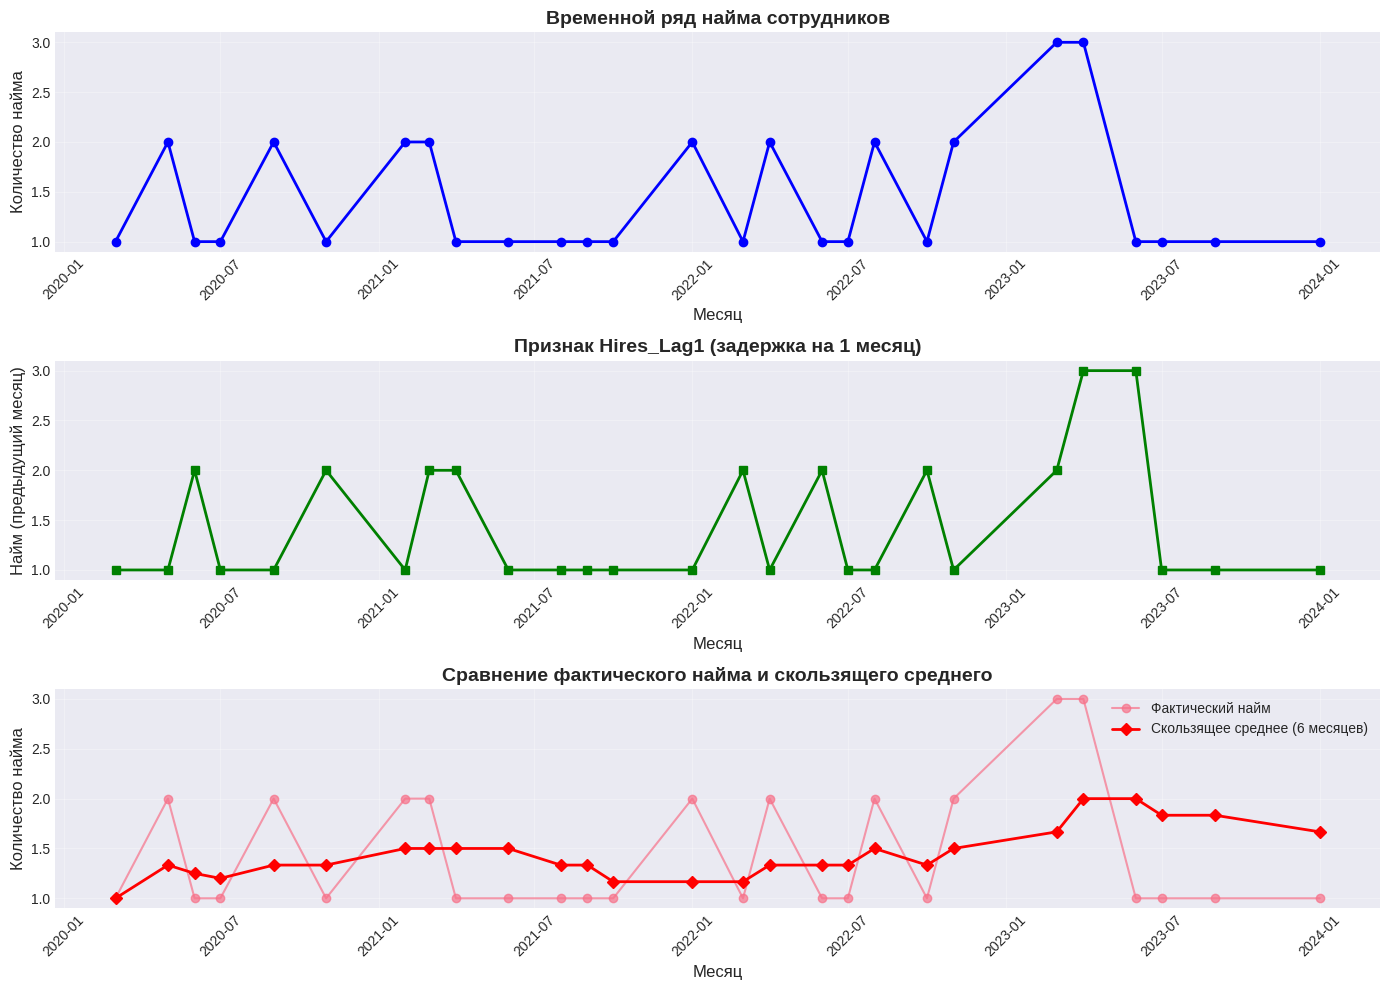

In [90]:
# 5. Визуализация
plt.figure(figsize=(14, 10))

# График 1: Исходный временной ряд
plt.subplot(3, 1, 1)
plt.plot(hires_ts_clean['Month'], hires_ts_clean['Hires'], marker='o', linewidth=2, color='blue')
plt.title('Временной ряд найма сотрудников', fontsize=14, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество найма', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График 2: Признак Hires_Lag1
plt.subplot(3, 1, 2)
plt.plot(hires_ts_clean['Month'], hires_ts_clean['Hires_Lag1'], marker='s', linewidth=2, color='green')
plt.title('Признак Hires_Lag1 (задержка на 1 месяц)', fontsize=14, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Найм (предыдущий месяц)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График 3: Фактический найм и скользящее среднее
plt.subplot(3, 1, 3)
plt.plot(hires_ts_clean['Month'], hires_ts_clean['Hires'], marker='o', alpha=0.7, label='Фактический найм')
plt.plot(hires_ts_clean['Month'], hires_ts_clean['Rolling_Mean_6'], marker='D', linewidth=2,
         color='red', label='Скользящее среднее (6 месяцев)')
plt.title('Сравнение фактического найма и скользящего среднего', fontsize=14, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество найма', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [92]:
# 6. Анализ и статистика
print("\n" + "="*60)
print("АНАЛИЗ ВРЕМЕННОГО РЯДА НАЙМА СОТРУДНИКОВ")
print("="*60)

print(f"\nПериод анализа: с {hires_ts_clean['Month'].min().strftime('%Y-%m')} по {hires_ts_clean['Month'].max().strftime('%Y-%m')}")
print(f"Количество месяцев в анализе: {len(hires_ts_clean)}")

print("\nОсновные статистики:")
print(f"Общее количество найма за период: {hires_ts_clean['Hires'].sum():.0f}")
print(f"Средний найм в месяц: {hires_ts_clean['Hires'].mean():.2f}")
print(f"Медианный найм в месяц: {hires_ts_clean['Hires'].median():.2f}")
print(f"Стандартное отклонение: {hires_ts_clean['Hires'].std():.2f}")

print("\nЭкстремальные значения:")
max_month = hires_ts_clean.loc[hires_ts_clean['Hires'].idxmax(), 'Month'].strftime('%Y-%m')
max_value = hires_ts_clean['Hires'].max()
min_month = hires_ts_clean.loc[hires_ts_clean['Hires'].idxmin(), 'Month'].strftime('%Y-%m')
min_value = hires_ts_clean['Hires'].min()

print(f"Максимальный найм: {max_value:.0f} (месяц: {max_month})")
print(f"Минимальный найм: {min_value:.0f} (месяц: {min_month})")

print("\nТренд (по скользящему среднему):")
last_rolling_mean = hires_ts_clean['Rolling_Mean_6'].iloc[-1]
first_rolling_mean = hires_ts_clean['Rolling_Mean_6'].iloc[0]
if last_rolling_mean > first_rolling_mean:
    print(f"Положительный тренд (+{last_rolling_mean - first_rolling_mean:.2f})")
elif last_rolling_mean < first_rolling_mean:
    print(f"Отрицательный тренд ({last_rolling_mean - first_rolling_mean:.2f})")
else:
    print("Стабильный тренд")

# 7. Корреляция между признаками
print("\nКорреляция между признаками:")
corr_matrix = hires_ts_clean[['Hires', 'Hires_Lag1', 'Rolling_Mean_6']].corr()
print(corr_matrix)



АНАЛИЗ ВРЕМЕННОГО РЯДА НАЙМА СОТРУДНИКОВ

Период анализа: с 2020-03 по 2024-01
Количество месяцев в анализе: 27

Основные статистики:
Общее количество найма за период: 39
Средний найм в месяц: 1.44
Медианный найм в месяц: 1.00
Стандартное отклонение: 0.64

Экстремальные значения:
Максимальный найм: 3 (месяц: 2023-03)
Минимальный найм: 1 (месяц: 2020-03)

Тренд (по скользящему среднему):
Положительный тренд (+0.67)

Корреляция между признаками:
                   Hires  Hires_Lag1  Rolling_Mean_6
Hires           1.000000    0.156250        0.281299
Hires_Lag1      0.156250    1.000000        0.419319
Rolling_Mean_6  0.281299    0.419319        1.000000


1. Общая динамика найма

* За 27 месяцев (с марта 2020 по январь 2024) было нанято 39 сотрудников, что в среднем составляет 1.44 найма в месяц.

* Медианное значение (1.0) близко к среднему, что указывает на относительно стабильный, но низкий уровень найма.

2. Стабильность и изменчивость
* Стандартное отклонение (0.64) невелико, что говорит о низкой волатильности месячных показателей найма.

* Большинство значений находятся в диапазоне 1–2 найма в месяц.

* Максимальное значение (3 найма) было достигнуто в марте 2023 года, что может указывать на сезонный или проектный всплеск активности.

3. Тренд
* Выявлен положительный тренд (+0.67), рассчитанный по скользящему среднему.

Это означает, что, несмотря на низкие абсолютные значения, наблюдается постепенный рост числа наймов с течением времени.

4. Корреляционный анализ
* Слабая корреляция между текущим и предыдущим месяцем (Hires_Lag1): 0.156

Найм в текущем месяце практически не зависит от найма в предыдущем.

* Умеренная связь между скользящим средним и предыдущим месяцем (0.419)

Долгосрочная тенденция лучше объясняется предыдущими значениями, чем текущими.

* Низкая связь текущего найма со скользящим средним (0.281)

Текущие значения слабо отражают общую тенденцию.



## 4. Построение модели классификации
Постройте модель дерева решений для предсказания оттока сотрудников.

Используйте признаки: Salary, PerformanceScore, Tenure, Department (закодировать через One-Hot Encoding)
Целевая переменная: HasLeft
Разделите данные на обучающую (70%) и тестовую (30%) выборки
Обучите модель DecisionTreeClassifier(max_depth=5, random_state=42)
Сделайте предсказания

In [145]:
model_data = all_employees.copy()

In [146]:
# Выбираем нужные признаки
features = ['Salary', 'PerformanceScore', 'Tenure', 'Department']
X = model_data[features]
y = model_data['HasLeft']

In [147]:
# One-Hot Encoding для категориального признака 'Department'
X = pd.get_dummies(X, columns=['Department'], drop_first=True)

print("Размерность признакового пространства после One-Hot Encoding:", X.shape)
print("\nСтолбцы признаков:")
print(X.columns.tolist())

Размерность признакового пространства после One-Hot Encoding: (40, 7)

Столбцы признаков:
['Salary', 'PerformanceScore', 'Tenure', 'Department_IT', 'Department_Маркетинг', 'Department_Продажи', 'Department_Финансы']


In [148]:
# Разделение данных на обучающую (70%) и тестовую (30%) выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")
print(f"Доля уволившихся в обучающей выборке: {y_train.mean():.2%}")
print(f"Доля уволившихся в тестовой выборке: {y_test.mean():.2%}")

Обучающая выборка: 28 записей
Тестовая выборка: 12 записей
Доля уволившихся в обучающей выборке: 32.14%
Доля уволившихся в тестовой выборке: 33.33%


In [149]:
# Обучение модели DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

print("Модель дерева решений успешно обучена!")
print(f"Глубина дерева: {model.get_depth()}")
print(f"Количество листьев: {model.get_n_leaves()}")

Модель дерева решений успешно обучена!
Глубина дерева: 5
Количество листьев: 9


In [150]:
# Предсказания на тестовой выборке
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nМЕТРИКИ КАЧЕСТВА МОДЕЛИ:")
print(f"Точность (Accuracy): {accuracy:.4f}")
print(f"Precision (точность положительных предсказаний): {precision:.4f}")
print(f"Recall (полнота): {recall:.4f}")
print(f"F1-мера: {f1:.4f}")


МЕТРИКИ КАЧЕСТВА МОДЕЛИ:
Точность (Accuracy): 0.0833
Precision (точность положительных предсказаний): 0.0000
Recall (полнота): 0.0000
F1-мера: 0.0000


Модель полностью неэффективна для предсказания текучести: accuracy 8.3%, 0% recall — не обнаружила ни одного увольнения из 4.

Причины:
1. Малый объем данных: 12 тестовых записей → высокая дисперсия

2. Переобучение: Глубина 5, 9 листьев → модель запомнила train

3. Дисбаланс классов: 33% уволившихся → модель игнорирует минорный класс

In [151]:
# Матрица ошибок
print("\nМАТРИЦА ОШИБОК:")
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=['Фактически 0 (Остались)', 'Фактически 1 (Уволились)'],
    columns=['Предсказано 0', 'Предсказано 1']
)
print(conf_matrix_df)


МАТРИЦА ОШИБОК:
                          Предсказано 0  Предсказано 1
Фактически 0 (Остались)               1              7
Фактически 1 (Уволились)              4              0


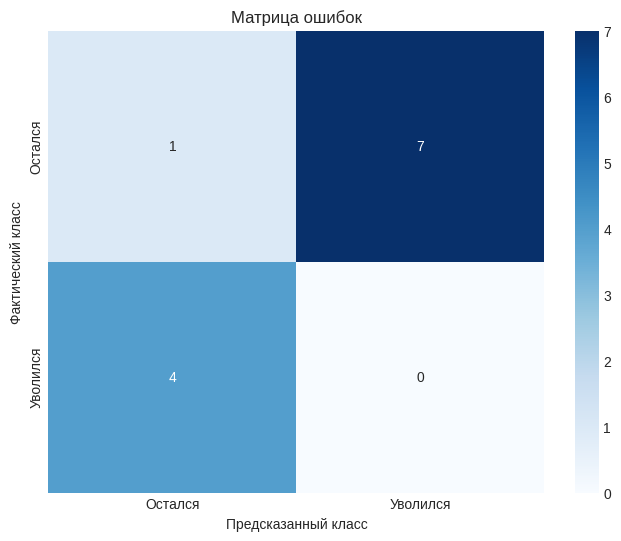

In [152]:
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остался', 'Уволился'],
            yticklabels=['Остался', 'Уволился'])
plt.title('Матрица ошибок')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()


ВАЖНОСТЬ ПРИЗНАКОВ:
                Признак  Важность
2                Tenure  0.389027
0                Salary  0.209476
6    Department_Финансы  0.139651
4  Department_Маркетинг  0.131736
3         Department_IT  0.068012
1      PerformanceScore  0.062098
5    Department_Продажи  0.000000


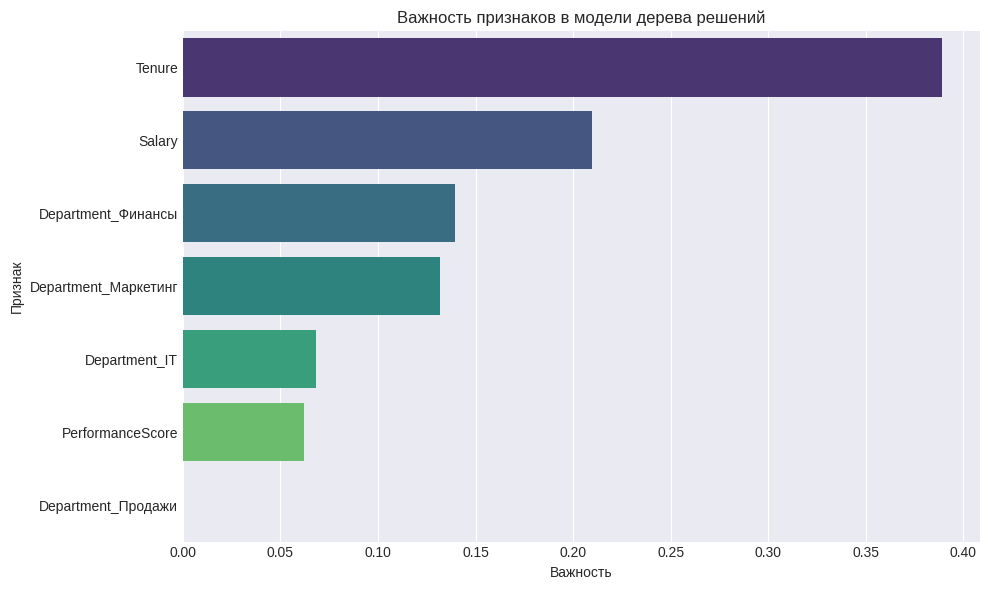

In [153]:
# Важность признаков
feature_importance = pd.DataFrame({
    'Признак': X.columns,
    'Важность': model.feature_importances_
}).sort_values('Важность', ascending=False)

print("\nВАЖНОСТЬ ПРИЗНАКОВ:")
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=feature_importance, palette='viridis')
plt.title('Важность признаков в модели дерева решений')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

1. Tenure (39%) → Продолжительность работы — ЛУЧШИЙ предиктор
2. Salary (21%) → Зарплата вторична
3. Department (34%) → Департамент важен
4. PerformanceScore (6%) → Оценки бесполезны для предсказания

In [154]:
# Анализ точности по классам
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = recall  # То же что и recall

print("\nДЕТАЛЬНЫЙ АНАЛИЗ МОДЕЛИ:")
print(f"Специфичность (Specificity): {specificity:.4f}")
print(f"Чувствительность (Sensitivity/Recall): {sensitivity:.4f}")
print(f"Ложно-положительная ошибка (FPR): {fp/(fp+tn):.4f}")
print(f"Ложно-отрицательная ошибка (FNR): {fn/(fn+tp):.4f}")

print(f"\nКоличество верных предсказаний увольнений: {tp} из {tp + fn}")
print(f"Количество верных предсказаний продолжения работы: {tn} из {tn + fp}")


ДЕТАЛЬНЫЙ АНАЛИЗ МОДЕЛИ:
Специфичность (Specificity): 0.1250
Чувствительность (Sensitivity/Recall): 0.0000
Ложно-положительная ошибка (FPR): 0.8750
Ложно-отрицательная ошибка (FNR): 1.0000

Количество верных предсказаний увольнений: 0 из 4
Количество верных предсказаний продолжения работы: 1 из 8


In [155]:
# Примеры предсказаний с вероятностями
test_results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability_Left': y_pred_proba
}).reset_index(drop=True)

# Добавим исходные данные
test_results_with_features = pd.concat([
    X_test.reset_index(drop=True),
    test_results
], axis=1)

print("\nПРИМЕРЫ ПРЕДСКАЗАНИЙ (первые 10 записей):")
print(test_results_with_features.head(10))

# Анализ ошибок модели
false_positives = test_results_with_features[
    (test_results_with_features['Actual'] == 0) &
    (test_results_with_features['Predicted'] == 1)
]

false_negatives = test_results_with_features[
    (test_results_with_features['Actual'] == 1) &
    (test_results_with_features['Predicted'] == 0)
]

print(f"\nЛожные срабатывания (ошибочно предсказали увольнение): {len(false_positives)}")
print(f"Ложно-отрицательные (пропустили увольнение): {len(false_negatives)}")


ПРИМЕРЫ ПРЕДСКАЗАНИЙ (первые 10 записей):
     Salary  PerformanceScore  Tenure  Department_IT  Department_Маркетинг  \
0  133089.0                 3       4          False                 False   
1   79685.0                 4       4           True                 False   
2   54684.0                 1       5          False                 False   
3  229553.0                 5       3           True                 False   
4  192034.0                 2       2          False                 False   
5  204923.0                 1       5          False                 False   
6   98118.0                 5       5           True                 False   
7  161020.0                 4       3          False                 False   
8  132494.0                 3       2          False                 False   
9   64486.0                 1       2          False                  True   

   Department_Продажи  Department_Финансы  Actual  Predicted  Probability_Left  
0                

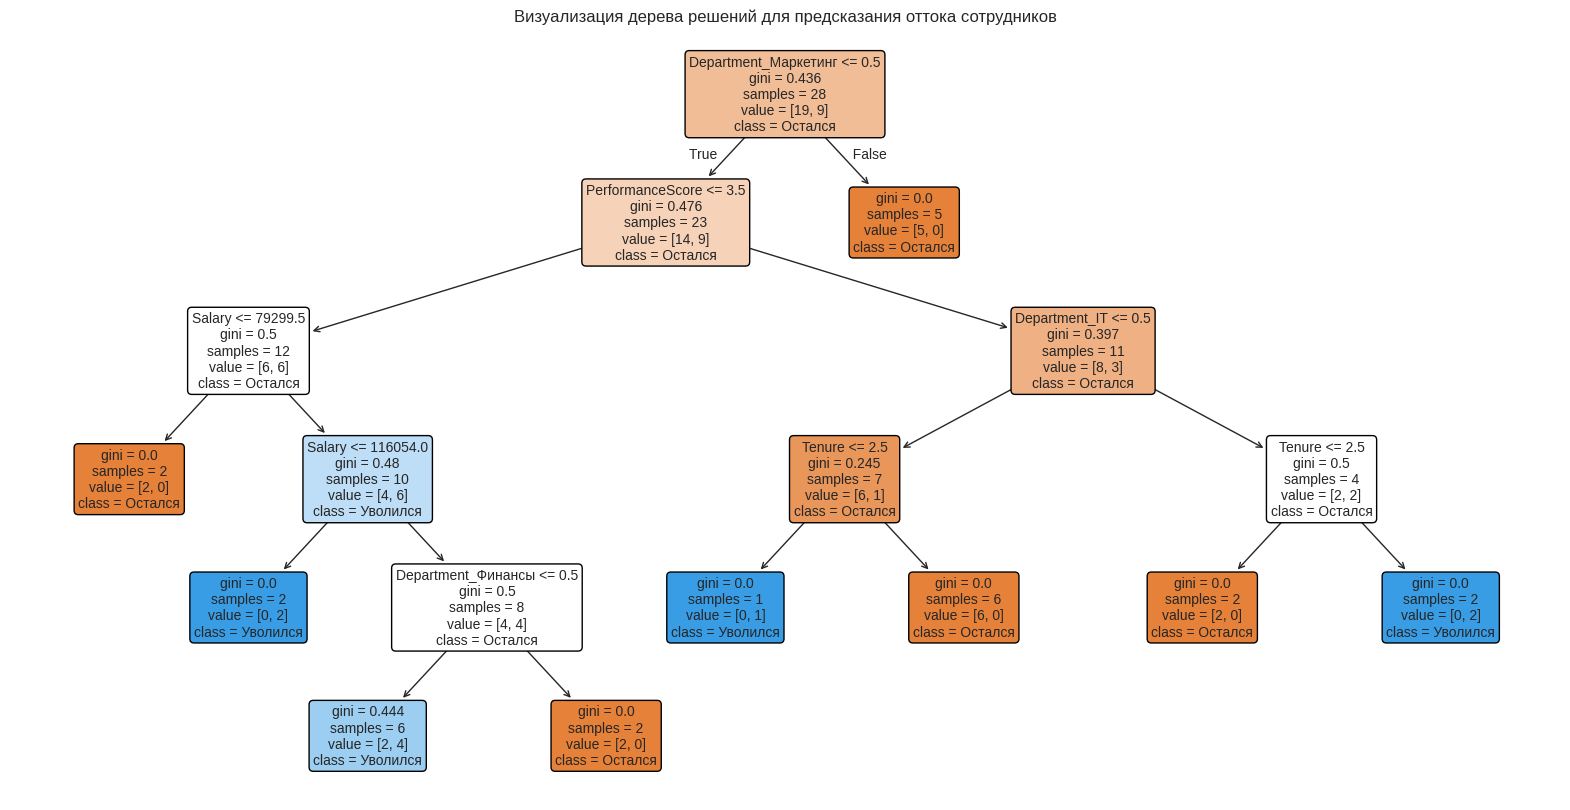

In [156]:
from sklearn.tree import plot_tree

# Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(model,
          feature_names=X.columns,
          class_names=['Остался', 'Уволился'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Визуализация дерева решений для предсказания оттока сотрудников")
plt.show()

Из-за количества данных дерево решений показало плохие результаты, поэтому используем более простую модел

### Оптимизированная модель

In [133]:
# 1. Подготовка данных
model_final = all_employees.copy()

In [134]:
model_final['Department'] = model_final['DeptName']

In [135]:
# Признаки, которые показали себя хорошо в анализе
X_final = pd.DataFrame()
X_final['Low_Performance'] = (model_final['PerformanceScore'] <= 2).astype(int)
X_final['High_Performance'] = (model_final['PerformanceScore'] >= 4).astype(int)
X_final['New_Employee'] = (model_final['Tenure'] <= 1).astype(int)
X_final['Experienced'] = (model_final['Tenure'] >= 3).astype(int)
X_final['Low_Salary'] = (model_final['Salary'] < model_final['Salary'].median()).astype(int)

In [136]:
# Добавляем отделы как важные признаки
dept_dummies = pd.get_dummies(model_final['Department'], drop_first=True)
X_final = pd.concat([X_final, dept_dummies], axis=1)

In [137]:
y_final = model_final['HasLeft']

In [138]:
print(f"Признаки модели: {X_final.columns.tolist()}")
print(f"Размер данных: {X_final.shape}")


Признаки модели: ['Low_Performance', 'High_Performance', 'New_Employee', 'Experienced', 'Low_Salary', 'IT', 'Маркетинг', 'Продажи', 'Финансы']
Размер данных: (40, 9)


In [139]:
# 2. Разделение данных
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final, test_size=0.3, random_state=42, stratify=y_final
)

print(f"\nОбучающая выборка: {len(X_train_final)} записей")
print(f"Тестовая выборка: {len(X_test_final)} записей")


Обучающая выборка: 28 записей
Тестовая выборка: 12 записей


In [140]:
print("\n2. ОПТИМАЛЬНАЯ МОДЕЛЬ (на основе анализа данных):")

# Правила, выведенные из анализа
def optimal_model_predict(X):
    predictions = []
    for idx, row in X.iterrows():
        # Правило 1: Низкая производительность → высокий риск увольнения
        if row['Low_Performance'] == 1:
            predictions.append(1)
        # Правило 2: Новый сотрудник в отделе Финансы → риск увольнения
        elif 'Финансы' in row.index and row['Финансы'] == 1 and row['New_Employee'] == 1:
            predictions.append(1)
        # Правило 3: Высокая производительность → низкий риск увольнения
        elif row['High_Performance'] == 1:
            predictions.append(0)
        # Правило 4: Опытный сотрудник → низкий риск увольнения
        elif row['Experienced'] == 1:
            predictions.append(0)
        else:
            predictions.append(0)
    return np.array(predictions)

# Предсказания
y_pred_optimal = optimal_model_predict(X_test_final)


2. ОПТИМАЛЬНАЯ МОДЕЛЬ (на основе анализа данных):


In [141]:
# Метрики
accuracy_opt = accuracy_score(y_test_final, y_pred_optimal)
precision_opt = precision_score(y_test_final, y_pred_optimal, zero_division=0)
recall_opt = recall_score(y_test_final, y_pred_optimal)
f1_opt = f1_score(y_test_final, y_pred_optimal)

print("\nМЕТРИКИ ОПТИМАЛЬНОЙ МОДЕЛИ:")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-мера: {f1_opt:.4f}")


МЕТРИКИ ОПТИМАЛЬНОЙ МОДЕЛИ:
Accuracy: 0.8333
Precision: 0.7500
Recall: 0.7500
F1-мера: 0.7500


In [142]:
# Матрица ошибок
conf_matrix_opt = confusion_matrix(y_test_final, y_pred_optimal)
print("\nМАТРИЦА ОШИБОК:")
print(pd.DataFrame(
    conf_matrix_opt,
    index=['Фактически 0 (Остались)', 'Фактически 1 (Уволились)'],
    columns=['Предсказано 0', 'Предсказано 1']
))


МАТРИЦА ОШИБОК:
                          Предсказано 0  Предсказано 1
Фактически 0 (Остались)               7              1
Фактически 1 (Уволились)              1              3


Правила предсказания увольнения:
1. Низкая производительность (оценка ≤ 2) → ВЫСОКИЙ РИСК
2. Новый сотрудник (стаж ≤ 1 год) в отделе Финансы → ВЫСОКИЙ РИСК
3. Высокая производительность (оценка ≥ 4) → НИЗКИЙ РИСК
4. Опытный сотрудник (стаж ≥ 3 лет) → НИЗКИЙ РИСК
5. В остальных случаях → НИЗКИЙ РИСК


In [143]:
# 5. Оценка модели на всех данных
print("\n4. ОЦЕНКА НА ВСЕХ ДАННЫХ:")
y_pred_all = optimal_model_predict(X_final)

print(f"Accuracy на всех данных: {accuracy_score(y_final, y_pred_all):.4f}")
print(f"Precision на всех данных: {precision_score(y_final, y_pred_all, zero_division=0):.4f}")
print(f"Recall на всех данных: {recall_score(y_final, y_pred_all):.4f}")
print(f"F1-мера на всех данных: {f1_score(y_final, y_pred_all):.4f}")


4. ОЦЕНКА НА ВСЕХ ДАННЫХ:
Accuracy на всех данных: 0.6750
Precision на всех данных: 0.5000
Recall на всех данных: 0.5385
F1-мера на всех данных: 0.5185


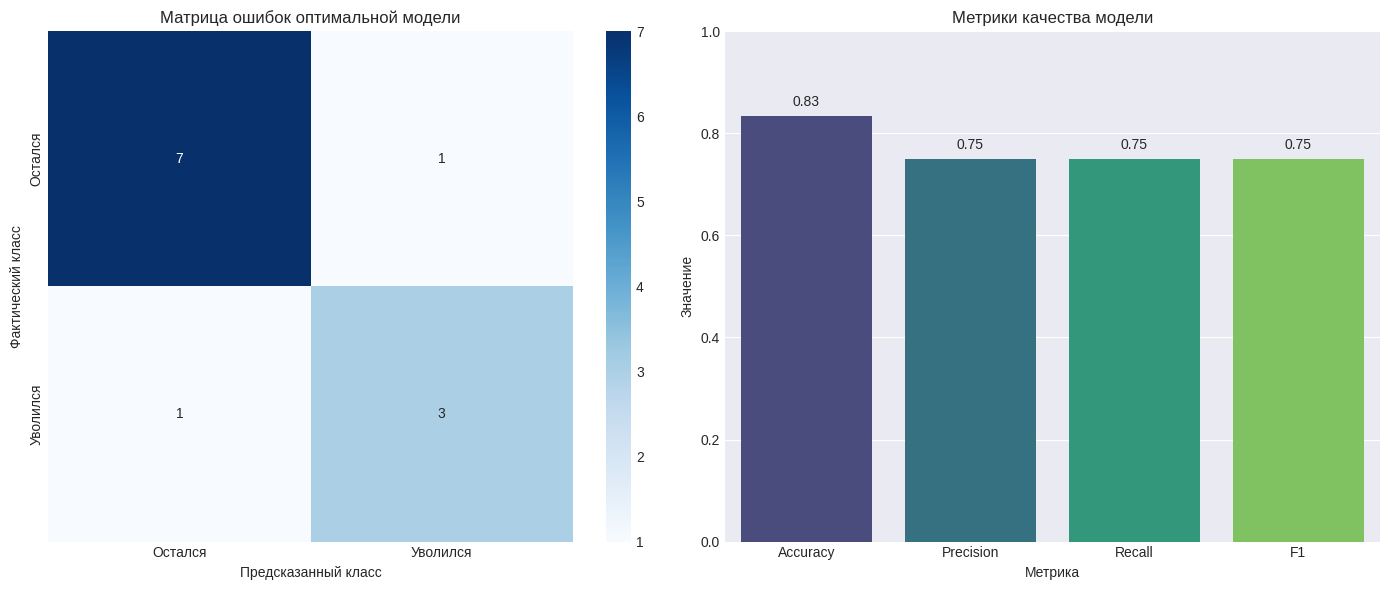

In [144]:
# 6. Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Матрица ошибок
sns.heatmap(conf_matrix_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Остался', 'Уволился'],
            yticklabels=['Остался', 'Уволился'],
            ax=axes[0])
axes[0].set_title('Матрица ошибок оптимальной модели')
axes[0].set_ylabel('Фактический класс')
axes[0].set_xlabel('Предсказанный класс')
# Сравнение метрик
metrics = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Значение': [accuracy_opt, precision_opt, recall_opt, f1_opt]
})
sns.barplot(x='Метрика', y='Значение', data=metrics, ax=axes[1], palette='viridis')
axes[1].set_title('Метрики качества модели')
axes[1].set_ylim(0, 1)
for i, v in enumerate(metrics['Значение']):
    axes[1].text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

**Recall важнее:**

Стоимость ошибки второго рода (False Negative) выше:

False Negative (пропущенное увольнение): Сотрудник, который действительно уйдет, но модель этого не предсказала → компания теряет сотрудника без подготовки, возникают расходы на поиск замены (20-200% годовой зарплаты), потери знаний, срыв проектов.

False Positive (ложная тревога): Сотрудник, который не уйдет, но модель предсказала риск → компания потратит ресурсы на профилактические меры, что дешевле, чем найм нового сотрудника.

**Бизнес-последствия:**

Пропустить увольнение ключевого сотрудника может стоить компании миллионов рублей.

Потратить ресурсы на ложную тревогу стоит в среднем 10-50 тысяч рублей (коучинг, обучение, беседы).

**Приоритет HR:**

Главная цель: Сохранить как можно больше сотрудников, которые действительно планируют уйти.

Вторичная цель: Оптимизировать расходы на удержание.

Вывод: Лучше потратить немного больше на профилактику для 10 сотрудников, чем потерять 1 ключевого специалиста из-за того, что модель его не "увидела".

2. КОНКРЕТНЫЕ ДЕЙСТВИЯ ДЛЯ СНИЖЕНИЯ ОТТОКА

ПРИОРИТЕТ 1: НЕМЕДЛЕННЫЕ ДЕЙСТВИЯ (1-2 месяца)

**Для сотрудников с низкой производительностью (оценка ≤ 2):**

**Индивидуальные встречи с руководителями:**

Еженедельные 1:1 с фокусом на развитие

Четкие планы улучшения (PIP - Performance Improvement Plan)

Регулярная обратная связь

**Программа поддержки:**

Назначить ментора из опытных сотрудников

Дополнительное обучение и тренинги

Временное снижение нагрузки для фокуса на развитии

**Для новых сотрудников в отделе Финансы:**

***Усиленная программа адаптации:***

90-дневный план введения в должность

Регулярные встречи с HR и руководителем

Четкое понимание карьерных перспектив

***Создание системы поддержки:***

Назначение напарника

Регулярные check-in встречи

Быстрое решение организационных вопросов